In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda, Dropout
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import tensorflow_datasets as tfds

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
(ds_train, ds_test_), ds_info = tfds.load('mnist',
                                          split=['train', 'test'],
                                          shuffle_files=True,
                                          as_supervised=True,
                                          with_info=True)

In [5]:
batch_size = 256

In [6]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image

In [7]:
ds_train =  ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(batch_size)
ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

In [8]:
# return label for testing

def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

In [9]:
ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

In [10]:
class GaussianSampling(Layer):
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means), mean=0, stddev=1.)
        samples = means + tf.exp(0.5*logvar)*epsilon
        
        return samples

In [11]:
class Encoder(Layer):
    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__(name=name)
        
        self.features_extract = Sequential([
            Conv2D(filters=8, kernel_size=(8,8), strides=2, padding='same', activation='relu'),
            Conv2D(filters=8, kernel_size=(8,8), strides=1, padding='same', activation='relu'),
            Conv2D(filters=8, kernel_size=(8,8), strides=2, padding='same', activation='relu'),
            Conv2D(filters=8, kernel_size=(8,8), strides=1, padding='same', activation='relu'),
            Flatten()])
        
        self.dense_mean = Dense(z_dim, name='mean')
        self.dense_logvar = Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()
        
    def call(self, inputs):
        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampler([mean, logvar])
        return z, mean, logvar

In [12]:
class Decoder(Layer):
    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__(name=name)
        
        self.forward = Sequential([
            Dense(7*7*64, activation='relu'),
            Reshape((7,7,64)),
            Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
            UpSampling2D((2,2)),
            Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
            UpSampling2D((2,2)),
            Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')])
    def call(self, inputs):
        return self.forward(inputs)

In [13]:
class VAE(Model):
    def __init__(self, z_dim, name='vae'):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.mean = None
        self.logvar = None
        
    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        out = self.decoder(z)
        return out

In [14]:
vae = VAE(z_dim=2)

In [15]:
def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5 * tf.reduce_mean(1 + vae.logvar - tf.square(vae.mean) - tf.exp(vae.logvar))
    return kl_loss

In [16]:
def vae_rc_loss(y_true, y_pred):
    rc_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return rc_loss

In [17]:
def vae_loss(y_true, y_pred):
    kl_loss = vae_kl_loss(y_true, y_pred)
    rc_loss = vae_rc_loss(y_true, y_pred)
    kl_weight_const = 1e-2
    return kl_weight_const*kl_loss + rc_loss

In [18]:
model_path = 'vae.h5'

In [19]:
checkpoint = ModelCheckpoint(model_path,
                             monitor='vae_rc_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',
                             save_weights_only=True)
early = EarlyStopping(monitor='vae_rc_loss',
                      mode='auto',
                      patience=5)
callbacks_list = [checkpoint, early]

In [20]:
vae.compile(
    loss = [vae_loss],
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[vae_kl_loss, vae_rc_loss])

In [ ]:
vae.fit(ds_train, validation_data=ds_test,
        epochs=50, callbacks=callbacks_list)

Epoch 1/50
235/235 [==============================] - ETA: 0s - loss: 0.2803 - vae_kl_loss: 0.6415 - vae_rc_loss: 0.2739
Epoch 1: vae_rc_loss improved from inf to 0.27388, saving model to vae.h5
235/235 [==============================] - 14s 14ms/step - loss: 0.2803 - vae_kl_loss: 0.6415 - vae_rc_loss: 0.2739 - val_loss: 0.2348 - val_vae_kl_loss: 1.3183 - val_vae_rc_loss: 0.2216
Epoch 2/50
234/235 [============================>.] - ETA: 0s - loss: 0.2297 - vae_kl_loss: 1.5082 - vae_rc_loss: 0.2146
Epoch 2: vae_rc_loss improved from 0.27388 to 0.21460, saving model to vae.h5
235/235 [==============================] - 2s 10ms/step - loss: 0.2297 - vae_kl_loss: 1.5082 - vae_rc_loss: 0.2146 - val_loss: 0.2257 - val_vae_kl_loss: 1.5501 - val_vae_rc_loss: 0.2102
Epoch 3/50
229/235 [============================>.] - ETA: 0s - loss: 0.2241 - vae_kl_loss: 1.6804 - vae_rc_loss: 0.2073
Epoch 3: vae_rc_loss improved from 0.21460 to 0.20717, saving model to vae.h5
235/235 [=========================

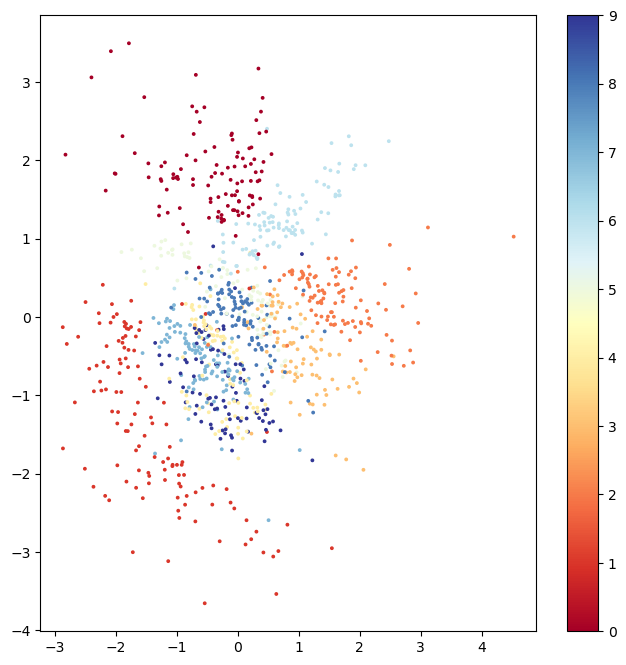

In [22]:
vae.load_weights(model_path)
images, labels = next(iter(ds_test_label))
outputs, z_means, z_logvar = vae.encoder(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()


In [25]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def explore_latent_variable(z1=(-5,5,0.1),
                            z2=(-5,5,0.1)):
    z_samples = np.array([[z1, z2]], dtype=np.float32)
    images = vae.decoder(z_samples)
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(images[0, :, :, 0], cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

In [26]:
z_samples = np.array([[z1, z2] for z2 in np.arange(-2.5, 2.5, 0.5) for z1 in np.arange(-2.5, 2.5, 0.5)], dtype=np.float32)
images = vae.decoder(z_samples)
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i = 0

for row in range(grid_row):
    for col in range(grid_col):
        axarr[row, col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row, col].axis('off')
        i += 1
plt.show()